In [ ]:
import os
from vibe.bash_config import write_bash

In [105]:
# --------- RUN a VIBE simulation ---------

upd_params = {
    'n_cpus': 24,
    'mem': '600GB',
    'yaml': 'Simulation_example_1.yaml'
}

bash_path = write_bash("bash", 10000, upd_params)
print("Generated:", bash_path)


Generated: /home/yu79deg/VIBE/bash/job.slurm


In [106]:
#################### LAUNCHING THE SIMULATION #################
os.system(f"sbatch {bash_path}")

Submitted batch job 6155571


0

In [115]:
#################### VISUALIZING THE QUEUE #################
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           6155571   hij-gpu Simulati  yu79deg CG    3:54:48      1 gpu001
           6159914   hij-gpu   LP_955  yu79deg PD       0:00      1 (Resources)
           6159915   hij-gpu   LP_956  yu79deg PD       0:00      1 (Priority)
           6159916   hij-gpu   LP_957  yu79deg PD       0:00      1 (Priority)
           6159917   hij-gpu   LP_958  yu79deg PD       0:00      1 (Priority)
           6159919   hij-gpu   LP_959  yu79deg PD       0:00      1 (Priority)
           6159920   hij-gpu   LP_960  yu79deg PD       0:00      1 (Priority)
           6159747   hij-gpu   LP_952  yu79deg  R       3:14      1 gpu002
           6159748   hij-gpu   LP_953  yu79deg  R       3:14      1 gpu003
           6159749   hij-gpu   LP_954  yu79deg  R       3:14      1 gpu004


In [114]:
!scancel 6155571

In [ ]:
##################### FLOW PLOT OF SIMULATIONS ####################
###################################################################

import importlib
import vibe.VIBE as vibe
importlib.reload(vibe)

from vibe.VIBE import flow_plot

%matplotlib widget


# Root of the VIBE repository
project_dir = "/home/yu79deg/VIBE/VIBE_outputs"

file = "LP_940"            # simulation name (YAML stem)
plot_channel = "main"      # "main", "VB_parr", "VB_perp"


# ------------ PLOTING PARAMETERS ---------
cl = [1e-15, 50]                  #Color scale (min, max) for the pcolor()
gyax_def = [-500, 500, 0.1]       # Vvertical axis (start, end, stepsize) (in [um])
vertical_type = 'center'          # (center, average_horiz)
log = 1                           # Log or linear scale
xl = None                         # Horizontal axis limits
flow_plot_crange = 1e-5           # Relative scale to plot images.
intensity_unit = "photons"        # "relative", "photons"

#==================================================#
flow_figs = 0          #save the flow figs (Pretty long to run!)
create_video_ff = 0    #create a video from the saved pictures
#==================================================#

# Call the function
flow_plot(project_dir, file, cl=cl, gyax_def=gyax_def,
          vertical_type=vertical_type, log=log, xl=xl,
          flow_figs=flow_figs, flow_plot_crange=flow_plot_crange,channel=plot_channel,unit=intensity_unit,include_flow=True)



if create_video_ff and flow_figs:
    image_dir = f"/home/yu79deg/VIBE/VIBE_outputs/flow_figs/{file}"
    output_file = "movie.mp4"
    framerate = 10
    video_images_path = ""
    input_pattern = f"{image_dir}/ff_%04d.png"
    !ffmpeg -framerate {framerate} -i "{input_pattern}" -c:v libx264 -pix_fmt yuv420p "{image_dir}/{output_file}"

In [ ]:
# =========================================================
# Simple Flow Plot (main + VB_perp overlay, photon units, aligned axes)
# =========================================================


from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import glob

# ---------------- USER SETTINGS ----------------
project_dir = Path("/home/yu79deg/VIBE/VIBE_outputs")
file_stem   = "LP_940"

figsize     = (10, 6)
log_scale   = True
alpha_min, alpha_max = 1e2, 1e4  # transparency scaling limits
# ------------------------------------------------


# ---------------- Colormaps ----------------
CMAP_MAIN = LinearSegmentedColormap.from_list(
    "main_map", ["#000000", "#001f5c", "#00bcd4", "#40e0d0", "#ffffff"], N=256
)
CMAP_VB = LinearSegmentedColormap.from_list(
    "VB_map",
    ["#000000", "#2b0b3f", "#2043a8", "#00bcd4",
     "#7bd100", "#ffe800", "#ff8a00", "#e53935", "#ffffff"], N=256
)
# ------------------------------------------------


# ---------------- Load data ----------------
pickles_dir = project_dir / "pickles"
main_path = sorted(glob.glob(str(pickles_dir / f"{file_stem}_main_summary.npz")))[0]
vb_path   = sorted(glob.glob(str(pickles_dir / f"{file_stem}_VB_perp_summary.npz")))[0]

d_main = np.load(main_path, allow_pickle=True)
d_vb   = np.load(vb_path, allow_pickle=True)

meta_main = d_main["meta"].item()
meta_vb   = d_vb["meta"].item()
if isinstance(meta_main, np.ndarray): meta_main = meta_main.item()
if isinstance(meta_vb, np.ndarray):   meta_vb = meta_vb.item()

scale_ph_main = meta_main.get("scale_ph", 1.0)
scale_ph_vb   = meta_vb.get("scale_ph", 1.0)

z_main = d_main["zax"]
z_vb   = d_vb["zax"]
gyax   = d_main["gyax"]

M_main = d_main["fixedfall"] * scale_ph_main
M_vb   = d_vb["fixedfall"]   * scale_ph_vb

# --- Align VB map to main z-axis ---
M_vb_aligned = np.full_like(M_main, np.nan)
for iy in range(M_vb.shape[1]):
    M_vb_aligned[:, iy] = np.interp(
        z_main, z_vb, M_vb[:, iy],
        left=np.nan, right=np.nan
    )

extent = [z_main.min(), z_main.max(), gyax.min(), gyax.max()]
# ------------------------------------------------


# ---------------- Create figure ----------------
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.12, 0.12, 0.75, 0.80])

# --- MAIN MAP ---
vmin_main = np.nanpercentile(M_main[M_main > 0], 1)
vmax_main = np.nanpercentile(M_main[M_main > 0], 99.9)
norm_main = LogNorm(vmin_main, vmax_main) if log_scale else None

im_main = ax.imshow(M_main.T, extent=extent, origin="lower", aspect="auto",
                    cmap=CMAP_MAIN, norm=norm_main)

# --- VB⊥ OVERLAY ---
vmin_vb = np.nanpercentile(M_vb[M_vb > 0], 1)
vmax_vb = np.nanpercentile(M_vb[M_vb > 0], 99.9)
norm_vb = LogNorm(vmin_vb, vmax_vb) if log_scale else None

tiny = 1e-30
arr_eff = np.log10(np.clip(M_vb_aligned, tiny, None))
a_min_eff = np.log10(alpha_min)
a_max_eff = np.log10(alpha_max)
alpha_vb = np.clip((arr_eff - a_min_eff) / (a_max_eff - a_min_eff), 0, 1)
alpha_vb[~np.isfinite(alpha_vb)] = 0
alpha_vb[M_vb_aligned <= 0] = 0

im_vb = ax.imshow(M_vb_aligned.T, extent=extent, origin="lower", aspect="auto",
                  cmap=CMAP_VB, norm=norm_vb, alpha=alpha_vb.T)

# ---------------- Labels ----------------
ax.set_xlabel("Propagation axis z [m]")
ax.set_ylabel("Transverse axis y [μm]")
ax.set_title(f"{file_stem} – Main + VB⊥ overlay (photon units)")

# ---------------- Two Colorbars ----------------
cb_main = plt.colorbar(im_main, ax=ax, fraction=0.035, pad=0.04)
cb_main.set_label("Main intensity [photons]")

cb_vb = plt.colorbar(im_vb, ax=ax, fraction=0.035, pad=0.10)
cb_vb.set_label("VB⊥ intensity [photons]")

plt.show()


Using: /home/yu79deg/VIBE/VIBE_outputs/pickles/LP_940_res.pickle
Selected channel: main


,z [m],Element,Transmission [%],Loss [%]
0,-11.0,start,0.5,99.5
1,-10.0,beam_shaper,0.5,99.5
2,-9.0,CRL3,93.5,6.5
3,-7.5,O1,100.0,0.0
4,-1.2,CRL4a,79.1,20.9
5,0.0,TCC,100.0,-0.0
6,1.0,reg1,100.0,0.0
7,2.1,A1-,10.6,89.4
8,2.1,A1,10.6,89.4
9,2.4,CRL4b,37.7,62.3


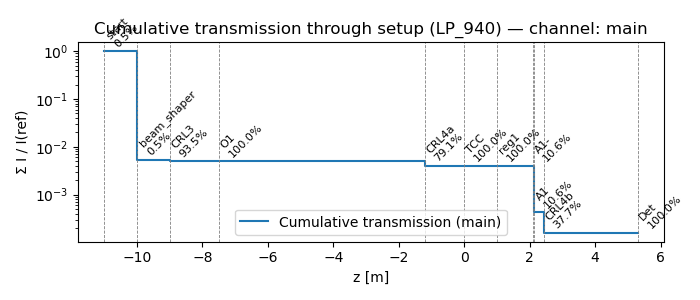

In [8]:
# ------------ TRUE TRANSMISSION PER ELEMENT (MULTI-CHANNEL CLEAN VERSION) -----------------
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget

# --- point to your run ---
projectdir = Path("/home/yu79deg/VIBE/VIBE_outputs")
filename   = "LP_940"   # same 'filename' used in the run
channel    = "main"  # choose: "main", "VB_perp", or "VB_parr"

# --- resolve pickle path (handles .pickle/.pkl) ---
base = projectdir / "pickles" / f"{filename}_res"
candidates = [p for ext in ("", ".pickle", ".pkl")
              if (p := (base if not ext else base.parent / (base.name + ext))).exists()]
if not candidates:
    candidates = sorted((base.parent).glob(base.name + "*"), key=lambda p: p.stat().st_mtime, reverse=True)
assert candidates, f"Couldn't find {base}[.pickle|.pkl]"
res_path = candidates[0]
print(f"Using: {res_path}")
print(f"Selected channel: {channel}")

# --- load pickle ---
elements_dict, params = pickle.load(open(res_path, "rb"))

# --- load trace data for selected channel ---
if channel == "main":
    z_trace = np.asarray(params.get("trace_z"), float)
    I_trace = np.asarray(params.get("trace_I"), float)
else:
    z_trace = np.asarray(params.get(f"trace_z_{channel}"), float)
    I_trace = np.asarray(params.get(f"trace_I_{channel}"), float)

assert z_trace.size and I_trace.size, f"This pickle lacks trace data for channel '{channel}'."

# --- build list of optical elements ---
elements = [(name, el.get("position", None)) for name, el in elements_dict.items()
            if name not in ("Xbeam", "IRLaser", "simulation") and "position" in el]
elements = sorted(elements, key=lambda e: e[1])

# --- restrict elements for VB channels (they start at TCC) ---
if channel in ("VB_perp", "VB_parr"):
    # find TCC position
    tcc_z = None
    for name, z in elements:
        if name == "TCC":
            tcc_z = z
            break
    # keep only elements after TCC
    elements = [(n, z) for n, z in elements if tcc_z is None or z > tcc_z]

# --- helper to find nearest trace index ---
def nearest(arr, value):
    return int(np.nanargmin(np.abs(arr - float(value))))

# --- compute per-element transmissions ---
rows = []
for name, z_el in elements:
    i_center = nearest(z_trace, z_el)
    i_before = max(i_center - 1, 0)
    i_after  = min(i_center + 1, len(z_trace) - 1)

    I_before, I_after = I_trace[i_before], I_trace[i_after]
    transmission = I_after / I_before if I_before > 0 else np.nan
    loss_pct = (1 - transmission) * 100

    rows.append({
        "z [m]": z_el,
        "Element": name,
        "Transmission [%]": transmission * 100,
        "Loss [%]": loss_pct,
    })

df = pd.DataFrame(rows)

# --- clean formatting ---
pd.options.display.float_format = "{:,.1f}".format
display(df)

# --- plot cumulative transmission ---
Iref = I_trace[0] if I_trace[0] != 0 else 1.0
trans = I_trace / Iref

fig, ax = plt.subplots(figsize=(7,3))
ax.step(z_trace, trans, where="post", color="tab:blue", label=f"Cumulative transmission ({channel})")
ax.set_yscale("log")
ax.set_xlabel("z [m]")
ax.set_ylabel("Σ I / I(ref)")
ax.set_title(f"Cumulative transmission through setup ({filename}) — channel: {channel}")

# annotate element names with transmission %
for _, row in df.iterrows():
    ax.axvline(row["z [m]"], color="gray", lw=0.6, ls="--")
    ax.text(row["z [m]"], trans[nearest(z_trace, row["z [m]"])] * 1.1,
            f"{row['Element']}\n{row['Transmission [%]']:.1f}%", fontsize=8,
            rotation=45, ha="left", va="bottom")

ax.legend()
fig.tight_layout()
plt.show()


In [ ]:
# --------------- GENERATE YAML FILES FOR SCANS -------------

!python /home/yu79deg/VIBE/yamls/yaml_2Dscan_O1A1Beamsize.py

In [ ]:
# ------------------- RUN A SIMULATION SCAN ------------------------
import re

def get_simulation_list(manual_list=None, start=None, end=None, prefix="LP"):
    if manual_list:
        return manual_list
    elif start is not None and end is not None:
        return [f"{prefix}_{i}" for i in range(start, end + 1)]
    else:
        raise ValueError("Either provide a manual list or a start and end value.")

# Example: extracted prefix from template
template_name = "LP_908.yaml"
match = re.match(r'([A-Za-z]+)_(\d+)\.yaml$', template_name)
prefix = match.group(1) if match else "LP"

# Choose your scan range
sim_names = get_simulation_list(start=918, end=941, prefix=prefix)

# SLURM params
upd_params = {
    'n_cpus': 24,
    'mem': '600GB',
}

path = os.path.join('/home/yu79deg/darkfield_p5438/bash')

# Loop and submit
for sim in sim_names:
    upd_params['yaml'] = sim + '.yaml'
    bash_path = write_bash(path, 10000, upd_params)
    print(f"Submitting {sim} with bash file: {bash_path}")
    os.system(f"sbatch {bash_path}")

!squeue --me



In [ ]:
# ===================================================================================
# =================      ANALYSE A 2D SIMULATION SCAN     ===========================
# ===================================================================================


import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from matplotlib.colors import LogNorm, Normalize


# =====================================================
# USER SETTINGS
# =====================================================

project_dir = Path("/home/yu79deg/VIBE/VIBE_outputs")
yaml_dir = project_dir / "yamls"
npz_dir  = project_dir / "pickles"

prefix   = "LP"
start_id = 918      
end_id   = 941

log_scale = True      # ← toggle log/linear scale

# ---- parameters we scan on X and Y ----
param_x_key   = "O1"
param_x_field = "size"
param_y_key   = "A1"
param_y_field = "size"

#param_x_key   = "O0"
#param_x_field = "defect_amplitude"
#param_y_key   = "O0"
#param_y_field = "defect_lambda"

# ---- metric to plot ----
metric = "VB_perp75"
#metric = "SNR_perp75" 

cmap = "gnuplot2"

vmin_user = None   # e.g. 1e2  or None
vmax_user = None   # e.g. 1e6  or None


# =====================================================
# HELPERS
# =====================================================

def load_summary(file):
    d = np.load(file, allow_pickle=True)
    return d["meta"].item()

def read_param(Y, key, field):
    """
    Reads a parameter (e.g., A1.size) with OFF-case detection.
    
    If 'in' is missing or =1 → return field normally
    If 'in' = 0           → return 0
    """
    if key not in Y:
        raise KeyError(f"Missing key {key}")

    obj = Y[key]
    is_on = obj.get("in", 1)  # default = 1 (ON)

    if not is_on:
        return 0.0  # object OFF → define size=0

    return obj.get(field, 0.0)


def extract_metric(meta, metric):
    VB  = meta.get("VB_photons", {})
    SF  = meta.get("shadow_factors", {})
    SNR = meta.get("SNR", {})

    if metric == "VB_parr13": return VB["VB_parr"].get(13e-6, np.nan)
    if metric == "VB_parr75": return VB["VB_parr"].get(75e-6, np.nan)
    if metric == "VB_perp13": return VB["VB_perp"].get(13e-6, np.nan)
    if metric == "VB_perp75": return VB["VB_perp"].get(75e-6, np.nan)

    if metric == "SNR_parr13": return SNR.get(("VB_parr", 13e-6), np.nan)
    if metric == "SNR_parr75": return SNR.get(("VB_parr", 75e-6), np.nan)
    if metric == "SNR_perp13": return SNR.get(("VB_perp", 13e-6), np.nan)
    if metric == "SNR_perp75": return SNR.get(("VB_perp", 75e-6), np.nan)

    if metric == "SF13": return SF.get("SFA13", np.nan)
    if metric == "SF75": return SF.get("SFA75", np.nan)

    return np.nan


# =====================================================
# COLLECT DATA
# =====================================================

X_vals, Y_vals, Z_vals = [], [], []

for sim_id in range(start_id, end_id + 1):
    simname = f"{prefix}_{sim_id}"

    yaml_file = yaml_dir / f"{simname}.yaml"
    npz_file  = npz_dir / f"{simname}_main_summary.npz"

    if not yaml_file.exists() or not npz_file.exists():
        print(f"Skipping {simname}: missing files.")
        continue

    # ---- read YAML ----
    with open(yaml_file, "r") as f:
        Y = yaml.safe_load(f)

    try:
        x_val = read_param(Y, param_x_key, param_x_field) * 1e6
        y_val = read_param(Y, param_y_key, param_y_field) * 1e6
    except Exception as e:
        print(f"⚠️ {e} in {simname}")
        continue

    # ---- read metric ----
    meta = load_summary(npz_file)
    z_val = extract_metric(meta, metric)

    X_vals.append(x_val)
    Y_vals.append(y_val)
    Z_vals.append(z_val)

X_vals = np.array(X_vals)
Y_vals = np.array(Y_vals)
Z_vals = np.array(Z_vals)


# =====================================================
# BUILD 2D GRID
# =====================================================

X_unique = np.sort(np.unique(X_vals))
Y_unique = np.sort(np.unique(Y_vals))

# Prepare grid
Zg = np.full((len(Y_unique), len(X_unique)), np.nan)

# Fill grid
for x, y, z in zip(X_vals, Y_vals, Z_vals):
    ix = np.where(X_unique == x)[0][0]
    iy = np.where(Y_unique == y)[0][0]
    Zg[iy, ix] = z


# =====================================================
# PLOT WITH PCOLORMESH (nonlinear spacing OK)
# =====================================================

plt.figure(figsize=(7, 6))

# ---- compute automatic vmin/vmax from data ----
Zpos = Zg[Zg > 0]  # positive values for log scale

if log_scale:
    if len(Zpos) == 0:
        raise ValueError("Cannot use log scale: all values are <= 0.")

    vmin_auto = max(np.nanmin(Zpos), 1e-30)
    vmax_auto = np.nanmax(Zpos)
else:
    vmin_auto = np.nanmin(Zg)
    vmax_auto = np.nanmax(Zg)

# ---- choose between user limits and automatic limits ----
vmin = vmin_user if vmin_user is not None else vmin_auto
vmax = vmax_user if vmax_user is not None else vmax_auto

# ---- normalization ----
if log_scale:
    norm = LogNorm(vmin=vmin, vmax=vmax)
    label = f"{metric} (log scale)"
else:
    norm = Normalize(vmin=vmin, vmax=vmax)
    label = f"{metric} (linear scale)"

# ---- grid for pcolormesh ----
X_mesh, Y_mesh = np.meshgrid(X_unique, Y_unique)

pcm = plt.pcolormesh(
    X_mesh, Y_mesh, Zg,
    cmap=cmap,
    norm=norm,
    shading="auto"
)

plt.colorbar(pcm, label=label)
plt.xlabel(f"{param_x_key} {param_x_field} [µm]")
plt.ylabel(f"{param_y_key} {param_y_field} [µm]")
plt.title(f"2D scan of {metric}")
plt.tight_layout()
plt.show()

